In [1]:
from pymongo import MongoClient
import re
import html.parser

from __future__ import print_function

# gensim
from gensim import corpora, models, similarities, matutils
from gensim.models import LdaMulticore
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import words
import nltk
import re
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import pandas as pd

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize

import numpy as np
import matplotlib.pyplot as plt 

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
client = MongoClient()
db = client.sample_100k

sample = db.sample_100k.find({
    "body": { "$exists": True },
    "$expr": { "$gt": [ { "$strLenCP": "$body"}, 300 ]} 
                                    },{
    "body": 1})

In [4]:
sample = list(sample)

len(sample)

15042

In [5]:
sample = [x['body'] for x in sample]

In [6]:
sample = [re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', string) for string in sample]

In [7]:
sample = [string.replace('\n', ' ') for string in sample]

In [8]:
sample[4]

'###SexSells Stats for /u/shamelesslyunshaven * Verification: **Trusted Seller** [learn more](  * Account Age: **1652** Days | Karma: **31170** * No. of Listings: **100+** [view](  | No. of Reviews: **18** [view](   ---  [Wiki](  | [FAQ](  | [Bot Info](  | [Report a Bug](/message/compose/?to=irrational_function&amp;subject=SexStatsBot+Bug&amp;message=The+post+with+a+bug+is%3A+https%3A%2F%2Fredd.it%2F7sbg2p) | [Modmail](/message/compose/?to=%2Fr%2FSexsells)  --- ^(Version 0.6.8. Generated at: 03:10:08 UTC 2018-01-23)'

In [9]:
sample = [html.unescape(string) for string in sample]

In [10]:
sample[4]

'###SexSells Stats for /u/shamelesslyunshaven * Verification: **Trusted Seller** [learn more](  * Account Age: **1652** Days | Karma: **31170** * No. of Listings: **100+** [view](  | No. of Reviews: **18** [view](   ---  [Wiki](  | [FAQ](  | [Bot Info](  | [Report a Bug](/message/compose/?to=irrational_function&subject=SexStatsBot+Bug&message=The+post+with+a+bug+is%3A+https%3A%2F%2Fredd.it%2F7sbg2p) | [Modmail](/message/compose/?to=%2Fr%2FSexsells)  --- ^(Version 0.6.8. Generated at: 03:10:08 UTC 2018-01-23)'

# Attempting LDA

In [11]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit(sample)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [12]:
counts = count_vectorizer.transform(sample).transpose()

In [13]:
corpus = matutils.Sparse2Corpus(counts)

In [14]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [15]:
lda = LdaMulticore(workers=3, corpus=corpus, num_topics=5, id2word=id2word, passes=5)

2018-03-11 06:51:07,101 : INFO : using symmetric alpha at 0.2
2018-03-11 06:51:07,102 : INFO : using symmetric eta at 0.2
2018-03-11 06:51:07,170 : INFO : using serial LDA version on this node
2018-03-11 06:51:44,281 : INFO : running online LDA training, 5 topics, 5 passes over the supplied corpus of 15042 documents, updating every 6000 documents, evaluating every ~15042 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-11 06:51:44,285 : INFO : training LDA model using 3 processes
2018-03-11 06:51:44,443 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/15042, outstanding queue size 1
2018-03-11 06:51:47,162 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/15042, outstanding queue size 2
2018-03-11 06:51:49,877 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/15042, outstanding queue size 3
2018-03-11 06:51:49,904 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/15042, outstan

2018-03-11 06:53:09,299 : INFO : topic #3 (0.200): 0.003*"people" + 0.003*"just" + 0.003*"like" + 0.003*"don" + 0.002*"know" + 0.002*"think" + 0.002*"really" + 0.002*"good" + 0.001*"ve" + 0.001*"make"
2018-03-11 06:53:09,302 : INFO : topic #4 (0.200): 0.003*"like" + 0.003*"just" + 0.002*"don" + 0.002*"message" + 0.002*"think" + 0.002*"people" + 0.002*"time" + 0.002*"post" + 0.001*"automatically" + 0.001*"subreddit"
2018-03-11 06:53:09,305 : INFO : topic diff=0.468634, rho=0.324085
2018-03-11 06:53:15,163 : INFO : -11.702 per-word bound, 3332.7 perplexity estimate based on a held-out corpus of 1042 documents with 106542 words
2018-03-11 06:53:15,203 : INFO : PROGRESS: pass 2, dispatched chunk #0 = documents up to #2000/15042, outstanding queue size 1
2018-03-11 06:53:18,053 : INFO : PROGRESS: pass 2, dispatched chunk #1 = documents up to #4000/15042, outstanding queue size 2
2018-03-11 06:53:20,983 : INFO : PROGRESS: pass 2, dispatched chunk #2 = documents up to #6000/15042, outstanding

2018-03-11 06:55:02,984 : INFO : topic #2 (0.200): 0.004*"like" + 0.003*"just" + 0.003*"people" + 0.002*"don" + 0.002*"time" + 0.002*"make" + 0.001*"think" + 0.001*"ve" + 0.001*"really" + 0.001*"game"
2018-03-11 06:55:02,987 : INFO : topic #3 (0.200): 0.003*"just" + 0.003*"people" + 0.003*"like" + 0.003*"don" + 0.002*"know" + 0.002*"think" + 0.002*"really" + 0.001*"good" + 0.001*"ve" + 0.001*"make"
2018-03-11 06:55:02,989 : INFO : topic #4 (0.200): 0.003*"like" + 0.003*"just" + 0.002*"message" + 0.002*"post" + 0.002*"don" + 0.002*"subreddit" + 0.002*"automatically" + 0.002*"questions" + 0.002*"moderators" + 0.002*"think"
2018-03-11 06:55:02,992 : INFO : topic diff=0.182966, rho=0.294615
2018-03-11 06:55:03,047 : INFO : merging changes from 1042 documents into a model of 15042 documents
2018-03-11 06:55:06,478 : INFO : topic #0 (0.200): 0.003*"just" + 0.002*"like" + 0.002*"people" + 0.002*"don" + 0.002*"want" + 0.002*"time" + 0.002*"really" + 0.002*"think" + 0.001*"good" + 0.001*"going"

In [16]:
lda.print_topics(num_words=20)

2018-03-11 06:56:03,325 : INFO : topic #0 (0.200): 0.004*"just" + 0.002*"like" + 0.002*"people" + 0.002*"don" + 0.002*"want" + 0.002*"time" + 0.002*"really" + 0.002*"think" + 0.001*"good" + 0.001*"going" + 0.001*"bodybuilder" + 0.001*"bodybuilder bodybuilder" + 0.001*"ve" + 0.001*"use" + 0.001*"make" + 0.001*"know" + 0.001*"need" + 0.001*"got" + 0.001*"la" + 0.001*"right"
2018-03-11 06:56:03,331 : INFO : topic #1 (0.200): 0.003*"just" + 0.003*"like" + 0.003*"don" + 0.002*"time" + 0.002*"people" + 0.002*"think" + 0.001*"really" + 0.001*"know" + 0.001*"want" + 0.001*"ve" + 0.001*"good" + 0.001*"make" + 0.001*"need" + 0.001*"way" + 0.001*"right" + 0.001*"said" + 0.001*"ll" + 0.001*"going" + 0.001*"years" + 0.001*"say"
2018-03-11 06:56:03,337 : INFO : topic #2 (0.200): 0.004*"like" + 0.003*"just" + 0.003*"people" + 0.002*"don" + 0.002*"time" + 0.002*"make" + 0.001*"think" + 0.001*"ve" + 0.001*"really" + 0.001*"good" + 0.001*"game" + 0.001*"know" + 0.001*"way" + 0.001*"use" + 0.001*"want" +

[(0,
  '0.004*"just" + 0.002*"like" + 0.002*"people" + 0.002*"don" + 0.002*"want" + 0.002*"time" + 0.002*"really" + 0.002*"think" + 0.001*"good" + 0.001*"going" + 0.001*"bodybuilder" + 0.001*"bodybuilder bodybuilder" + 0.001*"ve" + 0.001*"use" + 0.001*"make" + 0.001*"know" + 0.001*"need" + 0.001*"got" + 0.001*"la" + 0.001*"right"'),
 (1,
  '0.003*"just" + 0.003*"like" + 0.003*"don" + 0.002*"time" + 0.002*"people" + 0.002*"think" + 0.001*"really" + 0.001*"know" + 0.001*"want" + 0.001*"ve" + 0.001*"good" + 0.001*"make" + 0.001*"need" + 0.001*"way" + 0.001*"right" + 0.001*"said" + 0.001*"ll" + 0.001*"going" + 0.001*"years" + 0.001*"say"'),
 (2,
  '0.004*"like" + 0.003*"just" + 0.003*"people" + 0.002*"don" + 0.002*"time" + 0.002*"make" + 0.001*"think" + 0.001*"ve" + 0.001*"really" + 0.001*"good" + 0.001*"game" + 0.001*"know" + 0.001*"way" + 0.001*"use" + 0.001*"want" + 0.001*"sure" + 0.001*"lot" + 0.001*"things" + 0.001*"going" + 0.001*"right"'),
 (3,
  '0.003*"just" + 0.003*"like" + 0.003

In [17]:
lda_corpus = lda[corpus]
lda_corpus

In [18]:
lda_docs = [doc for doc in lda_corpus]

In [19]:
lda_docs[55:60]

[[(0, 0.987381)],
 [(3, 0.9966879)],
 [(3, 0.988621)],
 [(3, 0.98727685)],
 [(1, 0.70794415), (4, 0.27869788)]]

In [20]:
sample[55]

"Friendship. First of all, you gotta target Maggie. Cut the head off of the snake. Then you align with April and Jennifer to try and take out Ivette. After she's gone, go for Cappy. You can then persuade Beau to align with you to take Jennifer out. Throw the final HoH to Beau and get him to evict April. In the jury, you'd get April, Jennifer, and Maggie. Beau gets Ivette and Cappy. 3-2, you have $500,000"

In [21]:
sample[59]

'Right?  I mean, is it our fault that white people are smart and awesome and black people are dumb and mess everything up?  It’s not racism if it’s fact.  -YoureRightOrWrong, [parent](   This subreddit and bot are not in any way affiliated with the moderators of /r/The_Donald. Direct questions about removal to them.'

# Doing TFIDF and LSA

In [22]:
# Vectorize the text using TFIDF
tfidf = TfidfVectorizer(stop_words="english", 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", #words with >= 2 alpha chars 
                        min_df=10,
                        ngram_range=(1, 4))
tfidf_vecs = tfidf.fit_transform(sample)

In [23]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(tfidf_vecs, 
                                                    sample, 
                                                    test_size=0.33)

# Train 
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Test 
nb.score(X_test, y_test)

0.009669621273166801

In [24]:
# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants 
# terms by docs instead of docs by terms
tfidf_corpus = matutils.Sparse2Corpus(tfidf_vecs.transpose())

# Row indices
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

# This is a hack for Python 3!
id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)

2018-03-11 06:56:37,110 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-11 06:56:37,408 : INFO : adding document #10000 to Dictionary(0 unique tokens: [])
2018-03-11 06:56:37,606 : INFO : built Dictionary(12169 unique tokens: ['wait', 'come', 'love', 'despite', 'classes']...) from 15042 documents (total 84609 corpus positions)


In [25]:
# Build an LSI space from the input TFIDF matrix, mapping of row id to word, and num_topics
# num_topics is the number of dimensions to reduce to after the SVD
# Analagous to "fit" in sklearn, it primes an LSI space
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=300)

2018-03-11 06:56:37,610 : INFO : using serial LSI version on this node
2018-03-11 06:56:37,610 : INFO : updating model with new documents
2018-03-11 06:56:37,715 : INFO : preparing a new chunk of documents
2018-03-11 06:56:37,863 : INFO : using 100 extra samples and 2 power iterations
2018-03-11 06:56:37,863 : INFO : 1st phase: constructing (12169, 400) action matrix
2018-03-11 06:56:38,312 : INFO : orthonormalizing (12169, 400) action matrix
2018-03-11 06:56:39,775 : INFO : 2nd phase: running dense svd on (400, 15042) matrix
2018-03-11 06:56:39,995 : INFO : computing the final decomposition
2018-03-11 06:56:39,996 : INFO : keeping 300 factors (discarding 12.499% of energy spectrum)
2018-03-11 06:56:40,114 : INFO : processed documents up to #15042
2018-03-11 06:56:40,120 : INFO : topic #0(15.664): 0.176*"message" + 0.171*"automatically" + 0.164*"subreddit" + 0.158*"moderators" + 0.157*"questions" + 0.145*"post" + 0.142*"contact" + 0.140*"action" + 0.140*"contact moderators" + 0.140*"bo

In [26]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lsi_corpus = lsi[tfidf_corpus]

# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]
doc_vecs[0]

[(0, 0.0319368137901028),
 (1, -0.056260125147759764),
 (2, -0.0031284663747666325),
 (3, -0.00019698620558758023),
 (4, 0.0038568488036380233),
 (5, 0.00157616661647633),
 (6, 0.0028403424451114963),
 (7, 0.002686308992695602),
 (8, -0.0012885561246620165),
 (9, 0.01699162638613476),
 (10, 0.035800019212000225),
 (11, -0.03999364159145895),
 (12, 0.0005355885699233811),
 (13, -0.0019133612197970423),
 (14, 0.007692305036355239),
 (15, 0.004683677728038578),
 (16, 0.017885126589394975),
 (17, -0.020183185777261387),
 (18, -0.0013397444037249213),
 (19, 0.012399305099946733),
 (20, 0.013632034471476945),
 (21, 0.005580557370104706),
 (22, 0.01375280830471858),
 (23, -0.010207262914932158),
 (24, -0.007344190391236854),
 (25, 0.0183470872292734),
 (26, 0.010781009623415605),
 (27, 0.006247492746303469),
 (28, 0.0029482821632483207),
 (29, -0.013711957265406966),
 (30, -0.008304667787423363),
 (31, 0.03473571328556014),
 (32, 0.025023722093841457),
 (33, -0.03397164815202469),
 (34, 0.001

In [27]:
# Create an index transformer that calculates similarity based on 
# our space
index = similarities.MatrixSimilarity(doc_vecs, 
                                      num_features=300)

# Return the sorted list of cosine similarities to the first document
sims = sorted(enumerate(index[doc_vecs[0]]), key=lambda item: -item[1])
sims

2018-03-11 06:56:41,603 : INFO : creating matrix with 15042 documents and 300 features


[(0, 1.0),
 (13408, 0.5640868),
 (11485, 0.42975083),
 (3087, 0.35646674),
 (12004, 0.35529476),
 (6461, 0.35323974),
 (10786, 0.3318185),
 (12804, 0.32850495),
 (14423, 0.32765472),
 (10138, 0.3219159),
 (6994, 0.32156116),
 (1429, 0.31219485),
 (5903, 0.3112072),
 (6939, 0.31101623),
 (14966, 0.3096057),
 (14353, 0.3092759),
 (3665, 0.30679148),
 (2060, 0.2996531),
 (5337, 0.29893106),
 (987, 0.29594254),
 (10328, 0.29466772),
 (9981, 0.28916955),
 (7826, 0.28394997),
 (1956, 0.28261197),
 (11785, 0.2791135),
 (10274, 0.27895302),
 (11020, 0.2765094),
 (8772, 0.27562147),
 (8783, 0.27527228),
 (7821, 0.2732725),
 (1944, 0.27105722),
 (9710, 0.26891974),
 (12688, 0.26696786),
 (9623, 0.26662937),
 (4008, 0.26551557),
 (13919, 0.26430354),
 (182, 0.26392618),
 (5459, 0.2638079),
 (3943, 0.26164368),
 (10077, 0.26035333),
 (14803, 0.2601334),
 (13825, 0.25884816),
 (3229, 0.25650623),
 (1855, 0.25586715),
 (6811, 0.2546415),
 (7219, 0.25282797),
 (21, 0.25246128),
 (1435, 0.2508315),
 (

In [28]:
# Let's take a look at how we did
for sim_doc_id, sim_score in sims[0:3]: 
    print("Score: " + str(sim_score))
    print("Document: " + sample[sim_doc_id])

Score: 1.0
Document: I can’t wait for more destroyers to come, would love to sail in the Fubuki, Ayanami, Akatsuki, and Uranami. Despite the are all Fubuki Classes (Type I, Type II, Type III, Type I Kai) their equipment is different. And has a unique history. Also would like to sail in  Hibiki in Soviet Tech tree or Yukikaze in Chinese Tech Tree.  >inb4 American Nagato
Score: 0.5640868
Document: Not really scary tho, the universe is huge, and the void, thus the aliens with their Type 4 technology is many many light years away from us, and they likely wont recognize our existence until we attain at least Type 2 or 3 status. There is actually an another recently discovered similar void with an another possible Type 4 civilization.  Whatever the truth is about these voids, we can't meet unless one of us reach Type 5 status. Our current Type 0 is just too small to even get their attention.
Score: 0.42975083
Document: I appreciate a mostly theoretical approach to type and function descripti

In [29]:
#Normalize the corpus
example = matutils.corpus2dense(lsi_corpus, num_terms=300).transpose()
example = normalize(example)

In [30]:
#Look at 2-20 clusters

SSEs = []
Sil_coefs = []
for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=54)
    km.fit(example)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(example, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

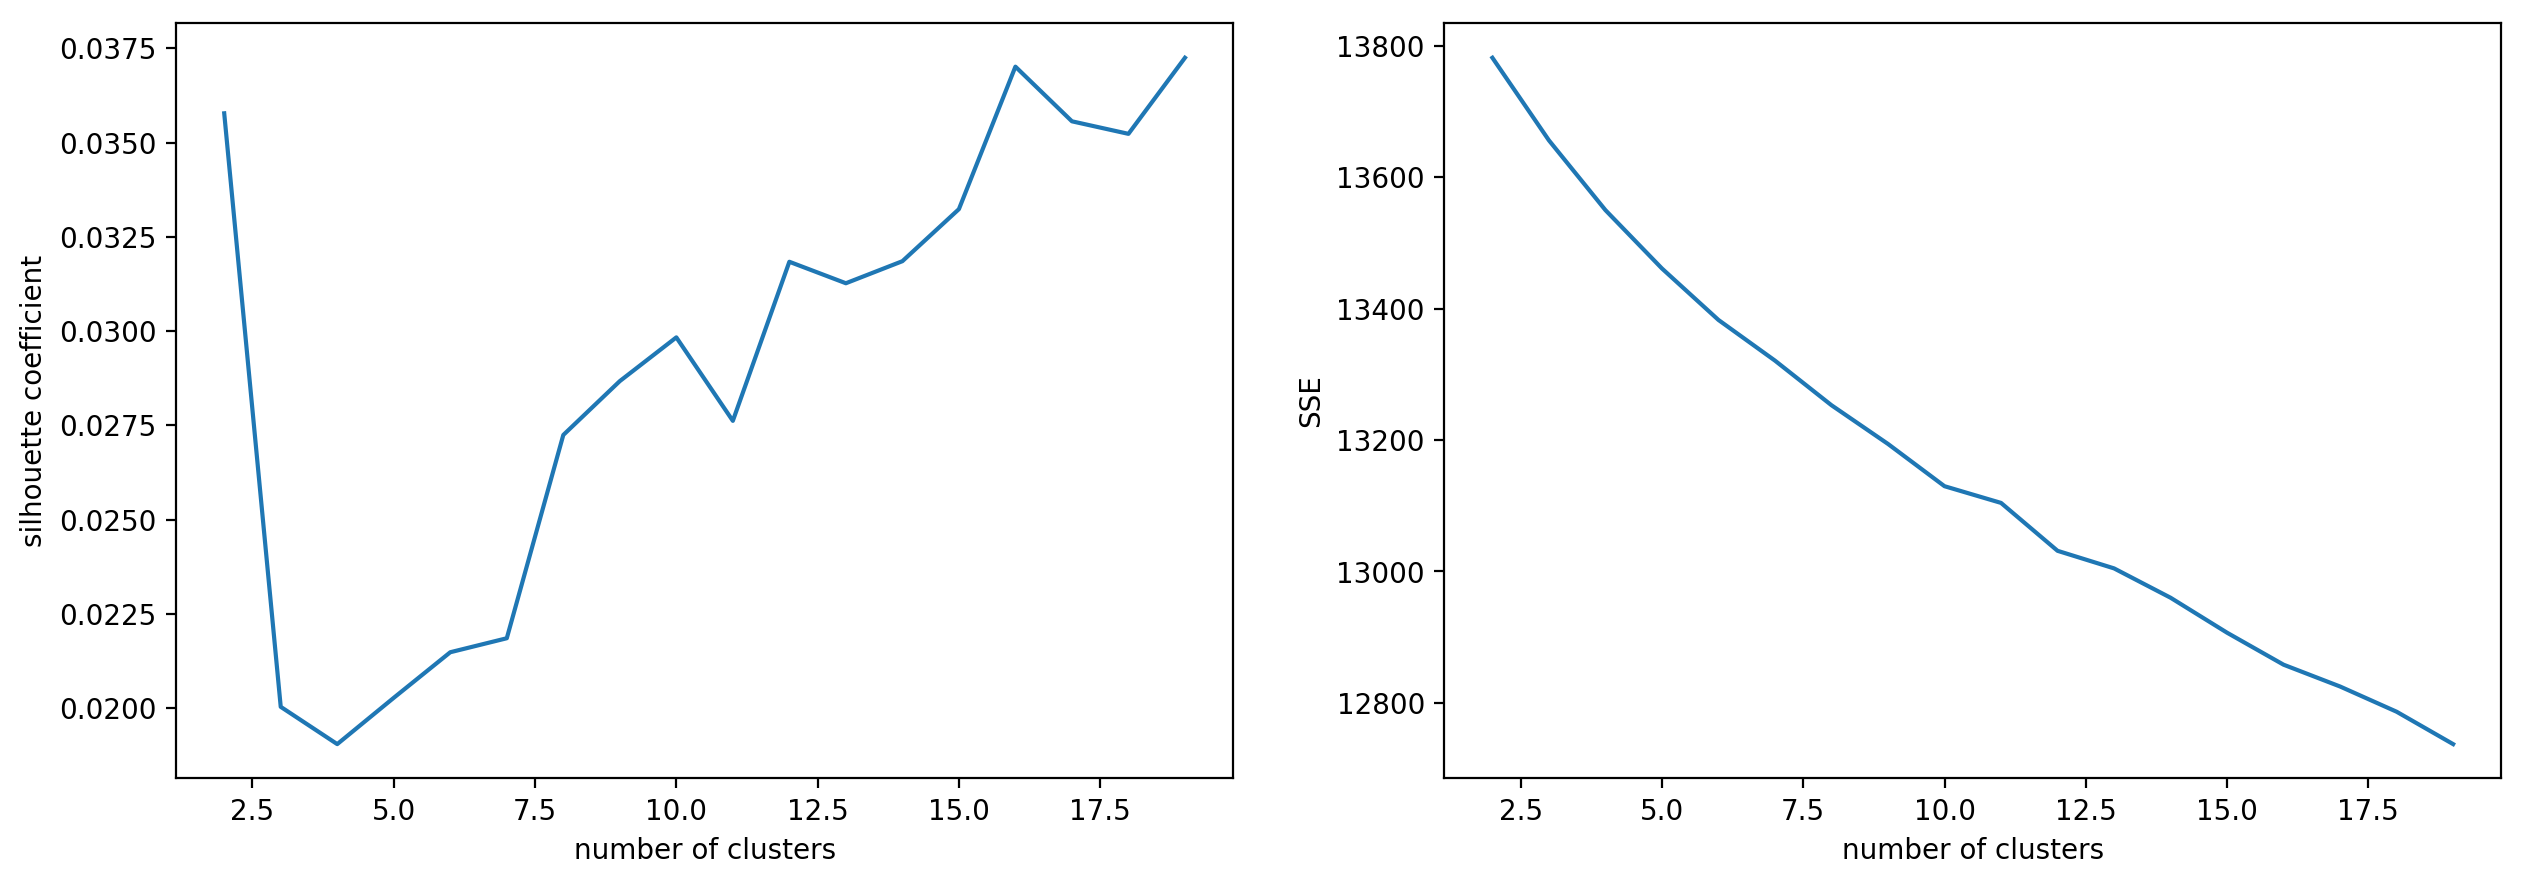

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

For n_clusters = 2 The average silhouette_score is : 0.035777964
For n_clusters = 3 The average silhouette_score is : 0.021089427
For n_clusters = 4 The average silhouette_score is : 0.01887949
For n_clusters = 5 The average silhouette_score is : 0.02031127
For n_clusters = 6 The average silhouette_score is : 0.021676945
For n_clusters = 7 The average silhouette_score is : 0.022433413
For n_clusters = 8 The average silhouette_score is : 0.022927815
For n_clusters = 9 The average silhouette_score is : 0.02454305
For n_clusters = 10 The average silhouette_score is : 0.02947777
For n_clusters = 11 The average silhouette_score is : 0.027538463
For n_clusters = 12 The average silhouette_score is : 0.031715106
For n_clusters = 13 The average silhouette_score is : 0.02760678
For n_clusters = 14 The average silhouette_score is : 0.034099303
For n_clusters = 15 The average silhouette_score is : 0.032292698
For n_clusters = 16 The average silhouette_score is : 0.031714465
For n_clusters = 17 The

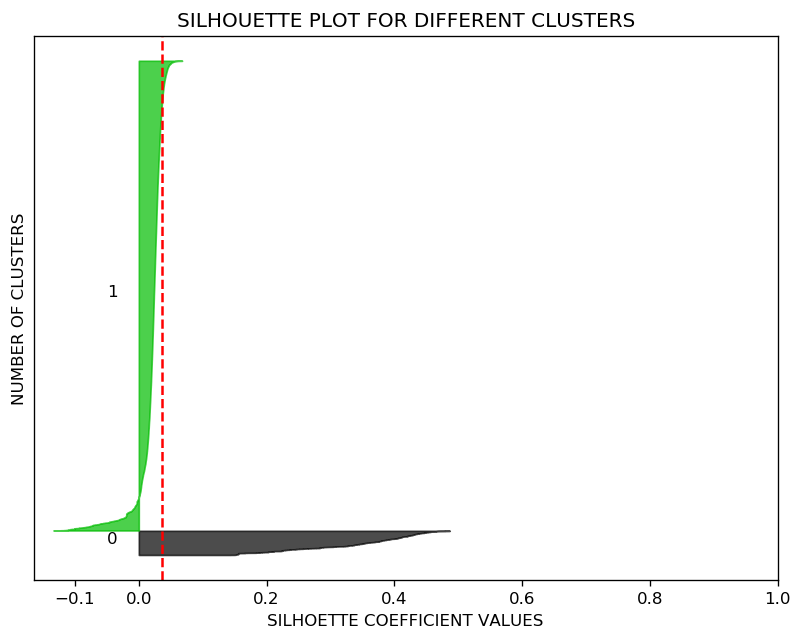

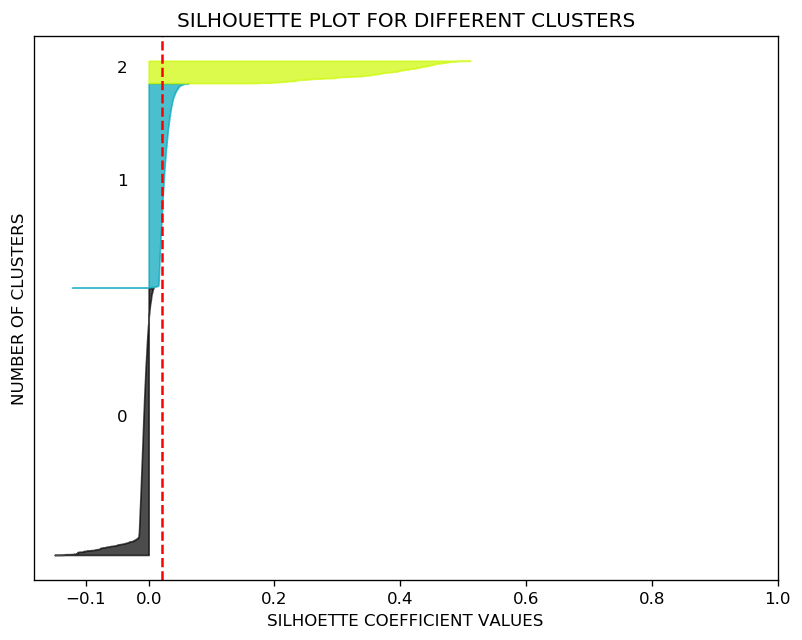

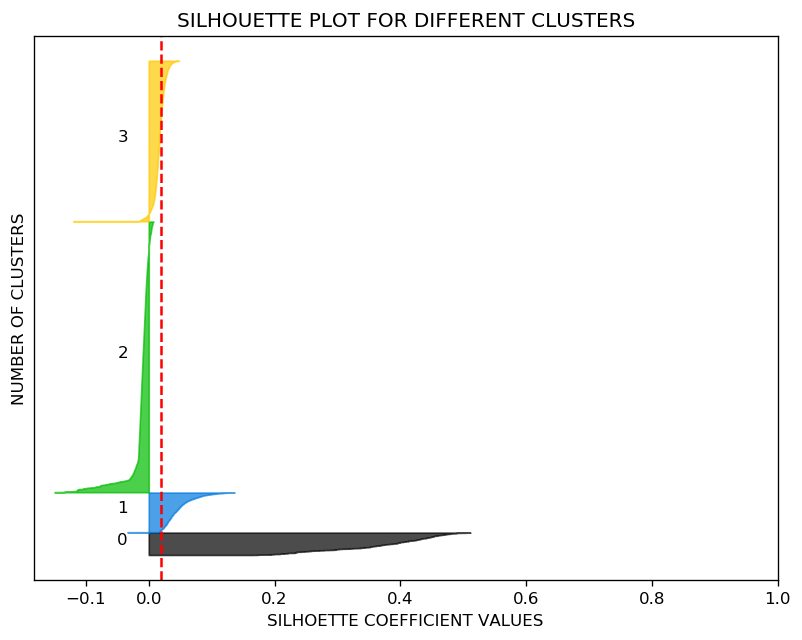

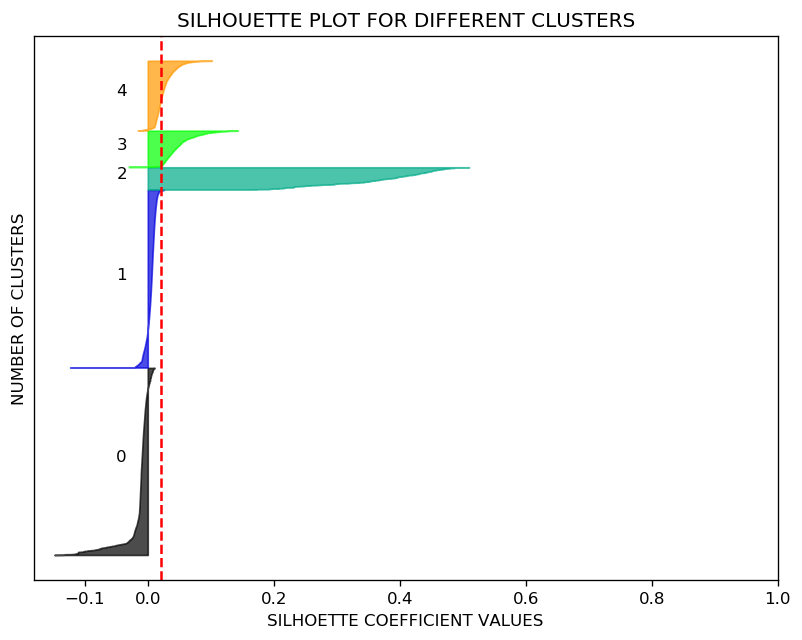

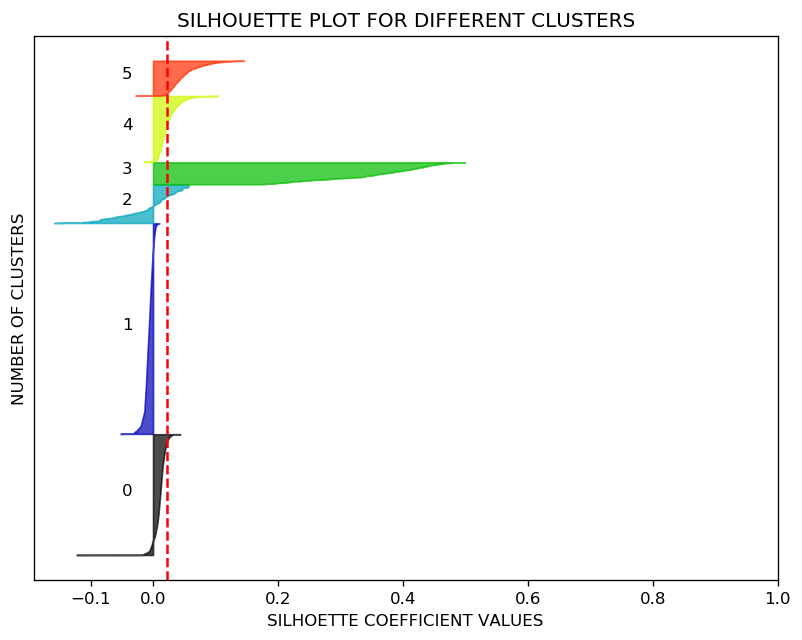

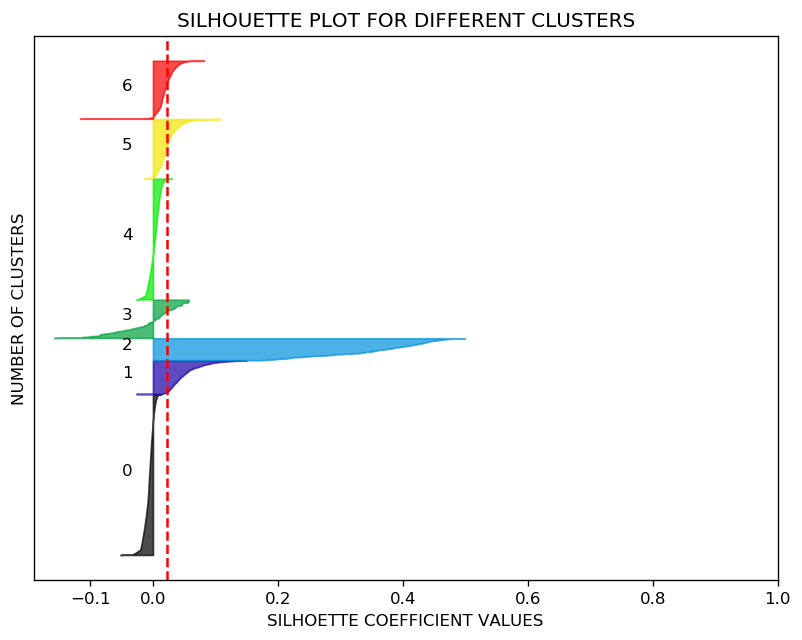

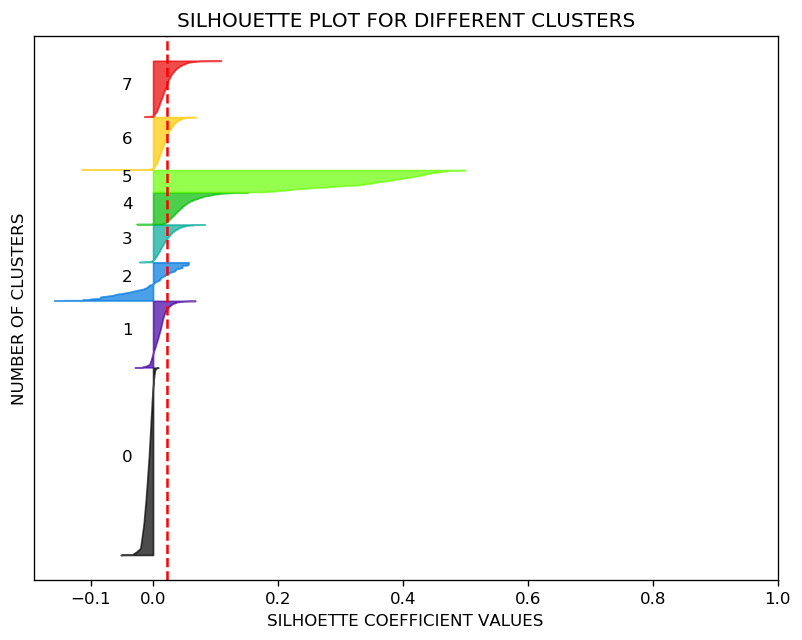

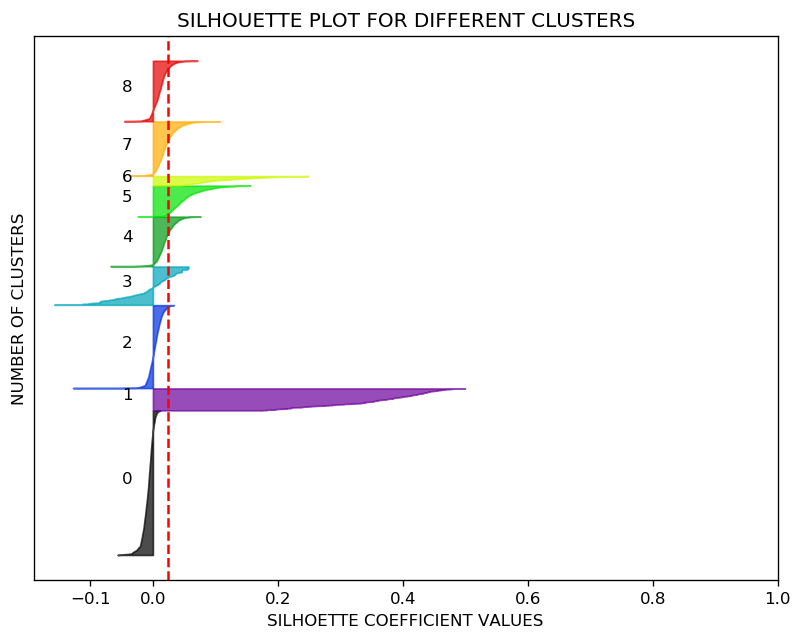

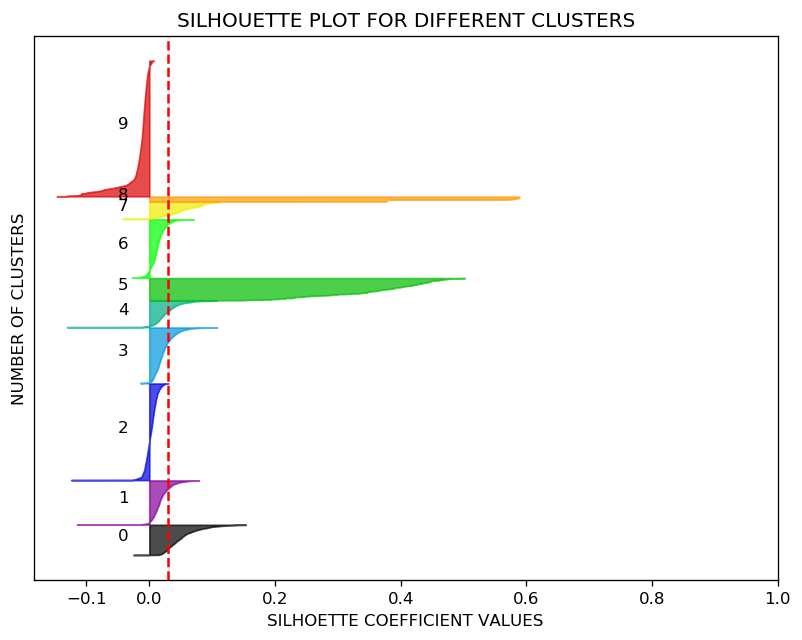

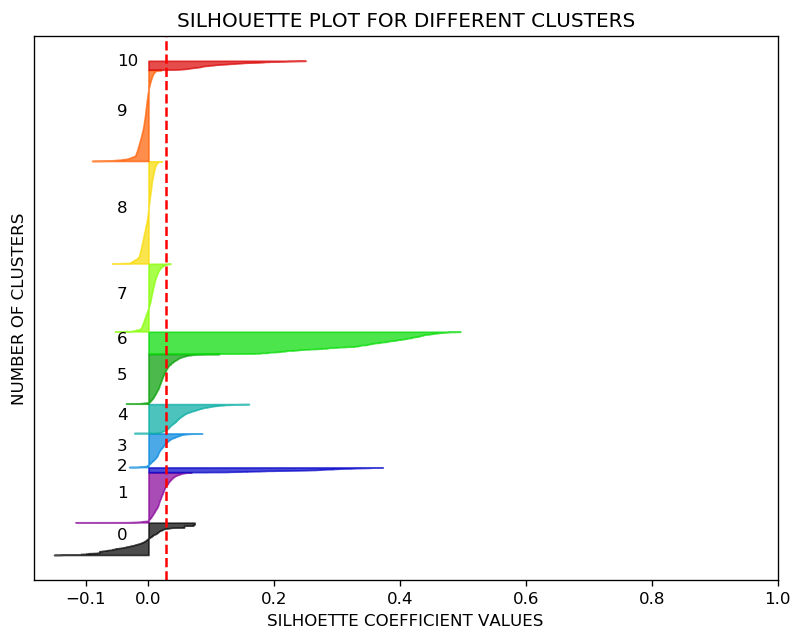

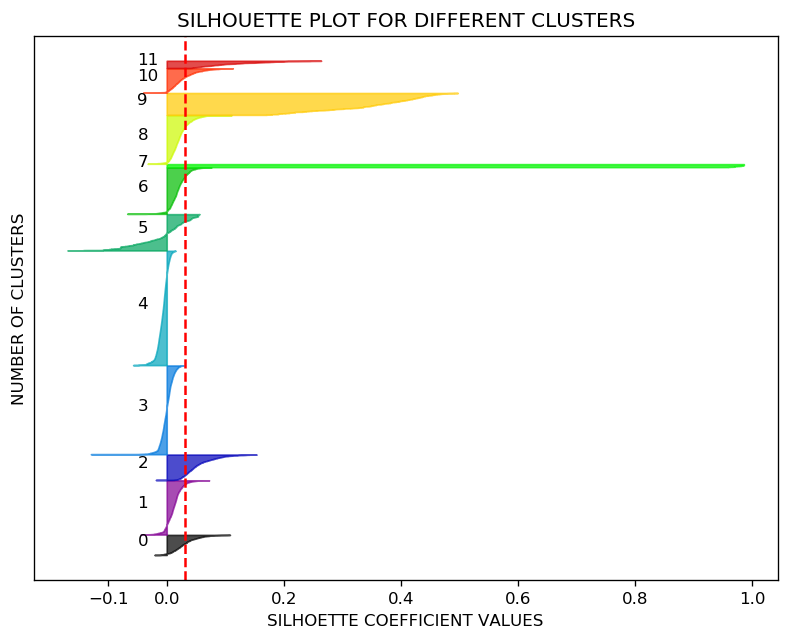

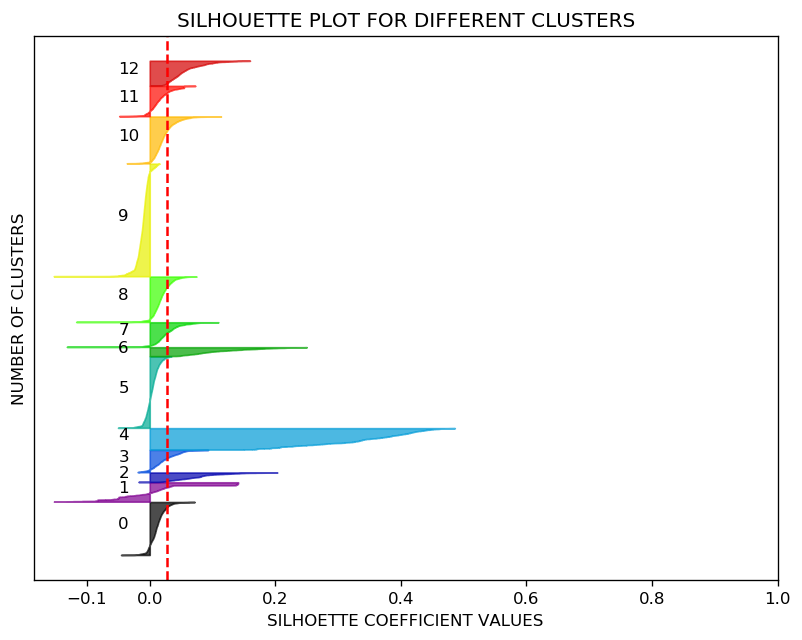

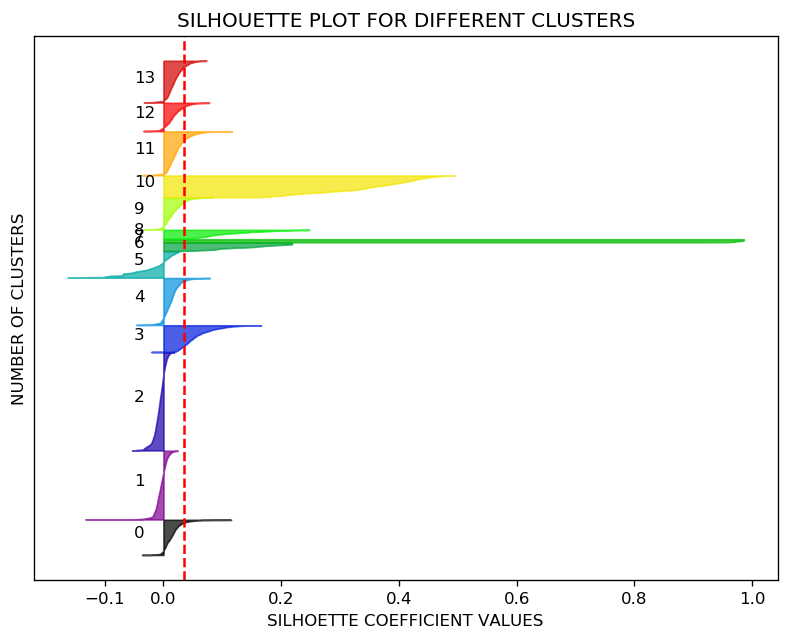

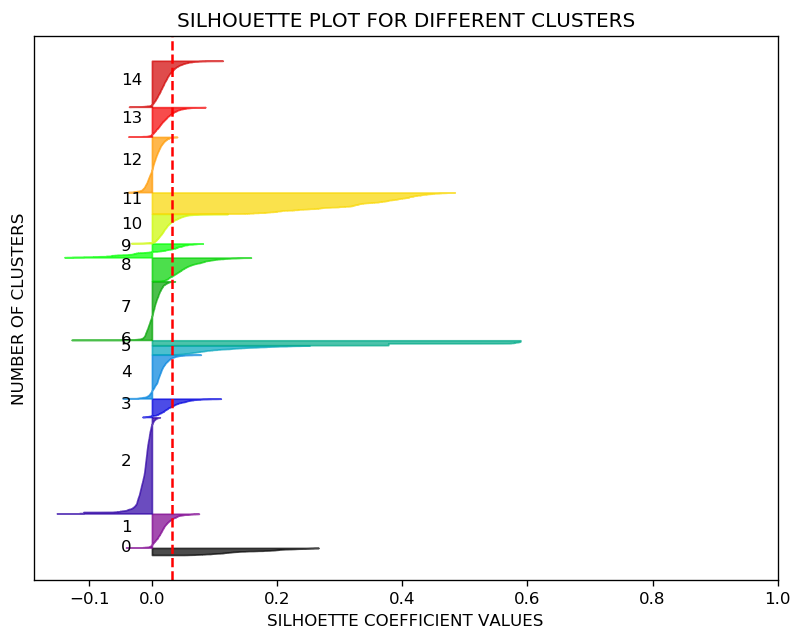

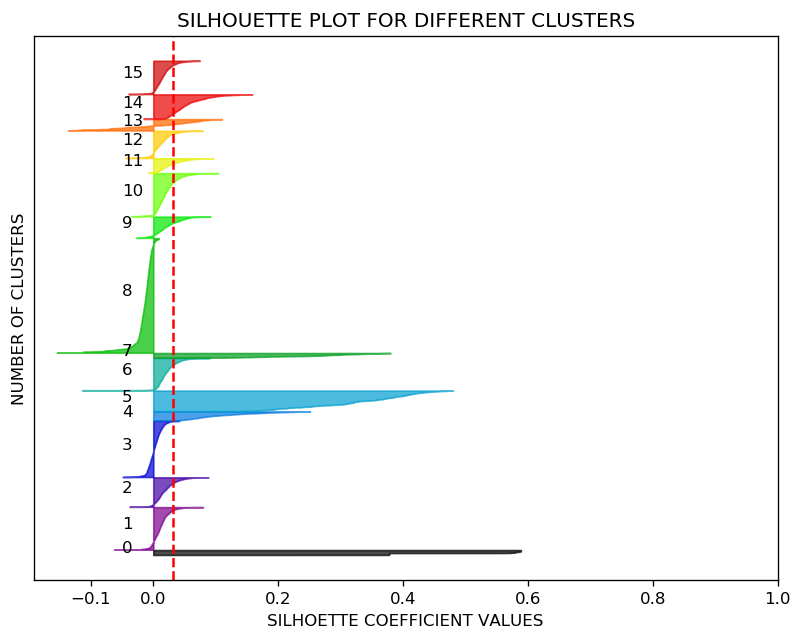

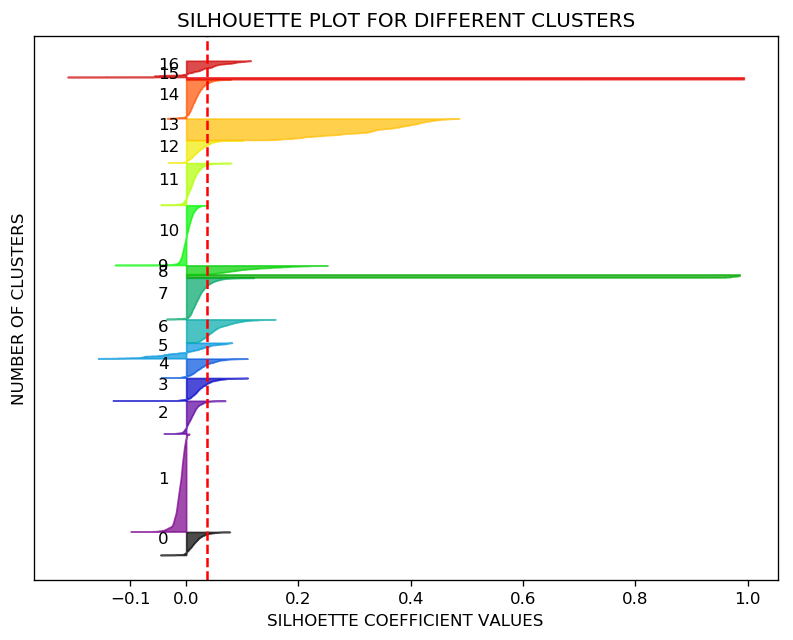

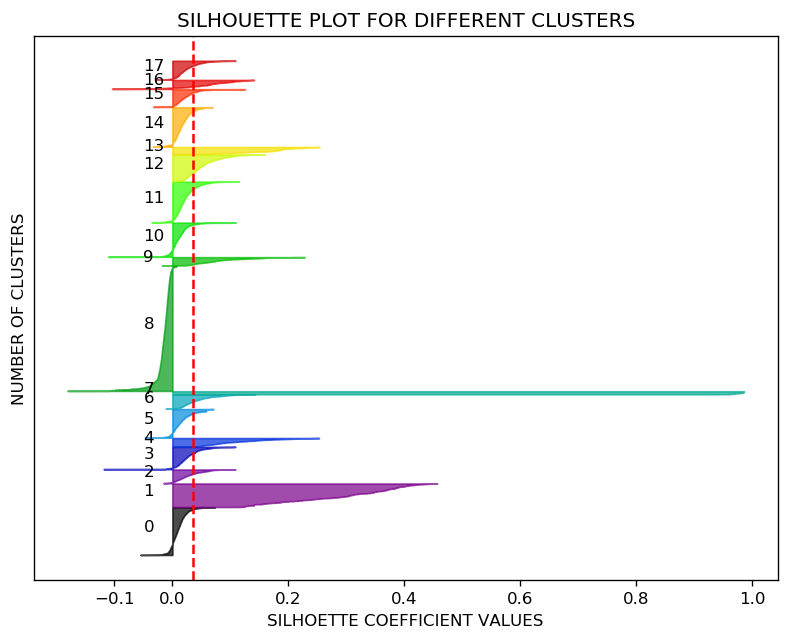

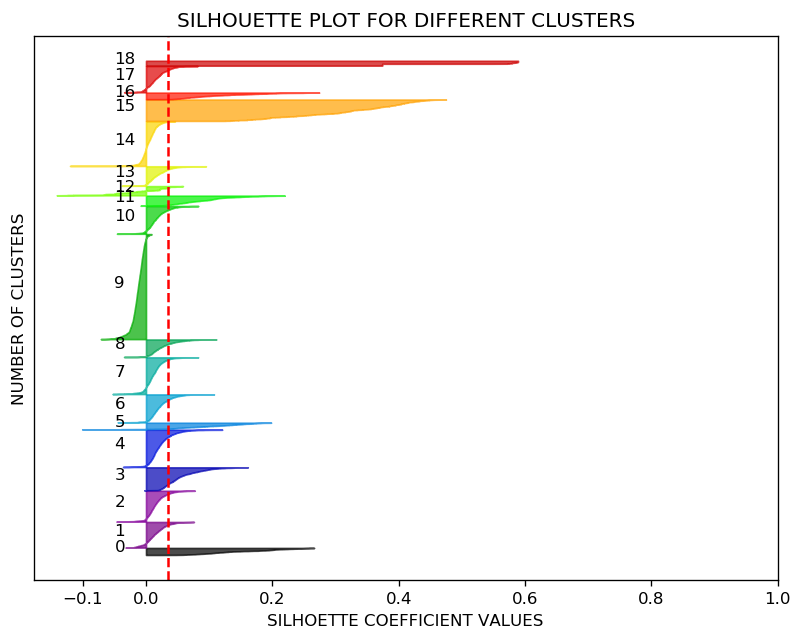

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score

for k in range(2,20):
    plt.figure(dpi=120, figsize=(8,6))
    ax1 = plt.gca()
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(example)
    labels = km.labels_
    silhouette_avg = silhouette_score(example, labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(example, labels)
    y_lower = 100
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("SILHOUETTE PLOT FOR DIFFERENT CLUSTERS")
    ax1.set_xlabel("SILHOETTE COEFFICIENT VALUES")
    ax1.set_ylabel("NUMBER OF CLUSTERS")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])